# K-means vector 2 dimensiones

## Grasas totales y azuar

In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids

In [2]:
ruta_csv = "../datasets/foundation-food.csv"
df = pd.read_csv(ruta_csv, sep=',')

In [3]:
df

,id,water,calories,protein,total_fat,sfa,mufa,pufa,cholesterol,carbs,...,folic_acid,folate,food_based_folate,vitamin_b12,vitamin_a,retinol,vitamin_e,vitamin_d,vitamin_k,nutrient_count
0,344604,NaN,24.0,0.81,0.41,NaN,NaN,0.0,0.0,4.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
1,344605,NaN,24.0,0.81,0.41,NaN,NaN,0.0,0.0,4.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2,344606,NaN,NaN,23.21,2.68,NaN,NaN,NaN,58.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
3,344607,NaN,NaN,23.21,2.68,NaN,NaN,NaN,58.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
4,344608,NaN,NaN,18.75,15.18,NaN,NaN,NaN,89.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448934,2206040,NaN,360.0,12.00,0.00,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
1448935,2206041,NaN,316.0,0.00,0.00,NaN,NaN,NaN,0.0,78.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
1448936,2206042,NaN,0.0,0.00,0.00,NaN,NaN,NaN,0.0,78.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
1448937,2206043,NaN,316.0,0.00,0.00,NaN,NaN,NaN,0.0,78.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [4]:
selected_cols = ['sugar', 'total_fat']

In [5]:
foods = df[selected_cols].copy()
foods = foods.sample(n=10000, random_state=42)

In [6]:
foods.head()

,sugar,total_fat
1055456,NaN,35.71
1050427,4.0,0.00
382750,NaN,NaN
309780,0.0,0.70
1246220,2.5,7.50


In [7]:
nulos_calories = foods['sugar'].isnull().sum()
nulos_protein = foods['total_fat'].isnull().sum()

print(f"Nulos en 'sugar': {nulos_calories}")
print(f"Nulos en 'total_fat': {nulos_protein}")

Nulos en 'sugar': 575
Nulos en 'total_fat': 173


In [8]:
# Eliminar los registros con valores nulos en 'sugar' o 'total_fat'
foods = foods.dropna(subset=selected_cols)

# Verificar el número de registros eliminados
print(f"Registros eliminados: {len(df) - len(foods)}")

Registros eliminados: 1439660


In [9]:
def show_boxplots(data, cols, prefix="", output_dir="./out-resources/boxplots"):
    for col in cols:
        # Imprimir la distribución estadística
        print(f"Distribución de '{col}':")
        print(data[col].describe())
        print("-" * 40)

        # Crear el gráfico
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=data[col])
        # plt.title(f'Boxplot de {col}')
        plt.xlabel(col)
        plt.tight_layout()

        # Guardar imagen
        filename = f"{prefix}_boxplot_{col}.png" if prefix else f"boxplot_{col}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath)
        print(f"Gráfico guardado en: {filepath}")
        
        plt.show()

In [10]:
# Función para detectar outliers (IQR)
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    return df[(df[columna] < limite_inf) | (df[columna] > limite_sup)].index

In [11]:
def plot_elbow_method(df, label, k_min=2, k_max=10):
    values = df.values
    inercias = []

    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(values)
        inercias.append(kmeans.inertia_)

    plt.figure(figsize=(6, 4), dpi=100)
    plt.plot(range(k_min, k_max), inercias, marker="o", color="red", lw=2)
    plt.xlabel("Número de Clusters")
    plt.ylabel("Inercia")
    plt.grid(True)
    plt.tight_layout()

    # Crear carpeta si no existe
    output_dir = "./out-resources/elbow_method/"
    os.makedirs(output_dir, exist_ok=True)

    filename = os.path.join(output_dir, f"{label}.png")
    plt.savefig(filename)
    print(f"Gráfico guardado como '{filename}'")

    plt.show()

## Outliners

Distribución de 'sugar':
count    9279.000000
mean       18.036677
std        67.396338
min         0.000000
25%         1.690000
50%         6.380000
75%        25.435000
max      5560.000000
Name: sugar, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/pre-fats-sugar_boxplot_sugar.png


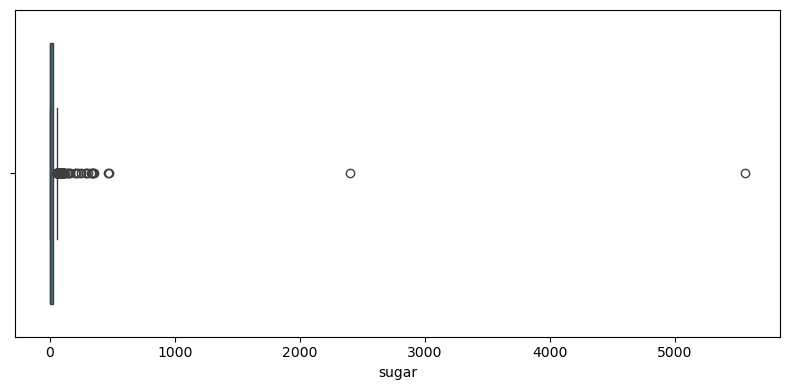

Distribución de 'total_fat':
count    9279.000000
mean       12.237569
std        22.975865
min         0.000000
25%         0.000000
50%         5.590000
75%        20.000000
max      1200.000000
Name: total_fat, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/pre-fats-sugar_boxplot_total_fat.png


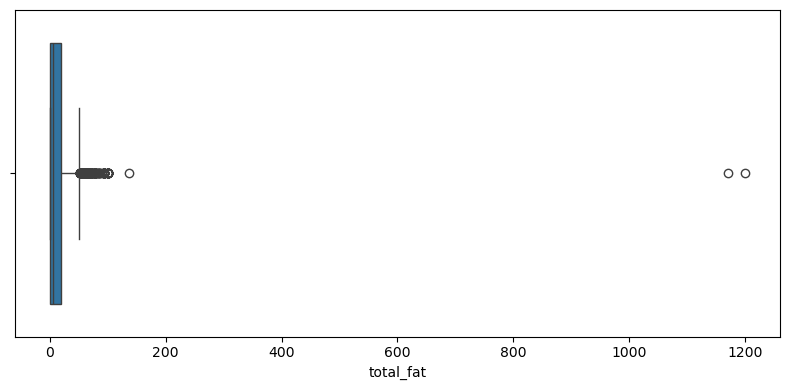

In [12]:
show_boxplots(foods, selected_cols, "pre-fats-sugar")

In [13]:
# Obtener índices de outliers para cada columna
outliers_sugar_idx = detectar_outliers(foods, 'sugar')
outliers_total_fat_idx = detectar_outliers(foods, 'total_fat')
# Unión de índices de outliers
todos_outliers = outliers_sugar_idx.union(outliers_total_fat_idx)
print(f"Número total de outliers (sodium o potassium): {len(todos_outliers)}")

# Eliminar outliers del DataFrame
foods_clean = foods.drop(index=todos_outliers)
print(f"Registros restantes tras eliminar outliers: {len(foods_clean)}")

Número total de outliers (sodium o potassium): 723
Registros restantes tras eliminar outliers: 8556


Distribución de 'sugar':
count    8556.000000
mean       13.209222
std        15.947624
min         0.000000
25%         1.430000
50%         5.410000
75%        21.350000
max        61.000000
Name: sugar, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/post-fats-sugar_boxplot_sugar.png


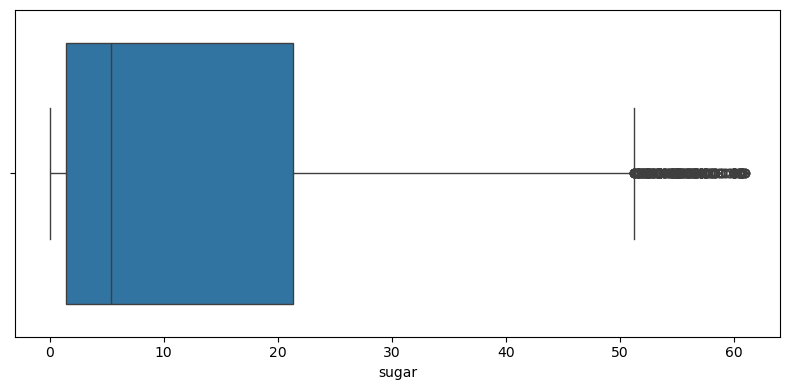

Distribución de 'total_fat':
count    8556.000000
mean       11.297101
std        12.926432
min         0.000000
25%         0.000000
50%         6.000000
75%        19.470000
max        50.000000
Name: total_fat, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/post-fats-sugar_boxplot_total_fat.png


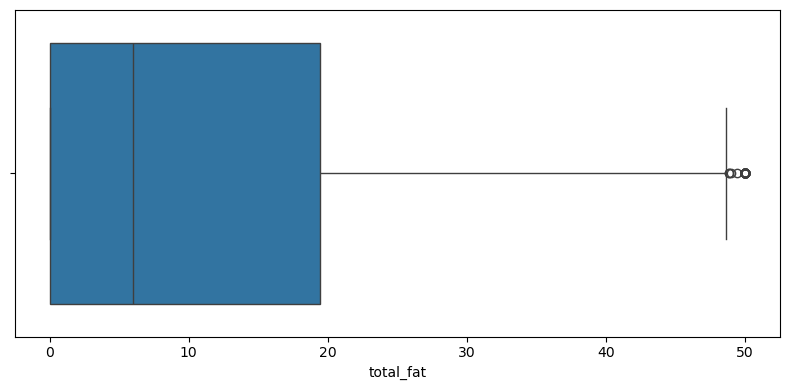

In [14]:
show_boxplots(foods_clean, selected_cols, "post-fats-sugar")

In [15]:
# Función para contar los outliers
def contar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)  # Primer cuartil
    Q3 = df[columna].quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartílico

    # Definir los límites inferior y superior
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Identificar los outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

    return outliers

# Contar los outliers para 'calories' y 'protein'
outliers_calories = contar_outliers(foods_clean, 'sugar')
outliers_protein = contar_outliers(foods_clean, 'total_fat')

# Imprimir el número de outliers
print(f"Número de outliers en 'sugar': {len(outliers_calories)}")
print(f"Número de outliers en 'total_fat': {len(outliers_protein)}")

Número de outliers en 'sugar': 321
Número de outliers en 'total_fat': 101


# K-means model

In [16]:
escalador = MinMaxScaler().fit(foods_clean.values)
foods_scaled = pd.DataFrame(escalador.transform(foods_clean.values), columns=selected_cols)

In [17]:
foods_scaled.head()

,sugar,total_fat
0,0.065574,0.0000
1,0.000000,0.0140
2,0.040984,0.1500
3,0.148197,0.0964
4,0.841803,0.0000


In [18]:
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42).fit(foods_scaled.values)
foods_scaled["cluster"] = kmeans.labels_

In [19]:
sil_kmeans = silhouette_score(foods_scaled.values, kmeans.labels_)
print('Silhouette Score', sil_kmeans)

Silhouette Score 0.8246013636446754


## Exportar modelo

In [20]:
import joblib

In [21]:
# Guardar el escalador
joblib.dump(escalador, "./models/fats-sugar-minmax-scaler.pkl")

# Guardar el modelo KMeans
joblib.dump(kmeans, "./models/fats-sugar-kmeans-model.pkl")

['./models/fats-sugar-kmeans-model.pkl']

## Export clustering csv

In [22]:
# Preparar información para CSV
foods_info = df.loc[foods_clean.index, ['id', 'sugar', 'total_fat']].copy()
foods_info['cluster'] = kmeans.labels_

# Limpiar saltos de línea en 'name'
# foods_info['name'] = foods_info['name'].str.replace(r'[\r\n]+', ' ', regex=True).str.strip()

# Exportar CSV
foods_info.to_csv("./out-csv/fats-sugar-clustering.csv", index=False)

## Data analysis

In [23]:
# Resumen mínimos y máximos por cluster
min_max_summary = foods_info.groupby('cluster')[selected_cols].agg(['min', 'max'])
print(min_max_summary)

         sugar        total_fat       
           min    max       min    max
cluster                               
0         0.00  20.63      0.00  17.24
1        18.18  60.98      0.00  20.00
2         0.00  25.00     17.28  50.00
3        22.03  61.00     15.00  50.00


In [24]:
# Conteo de registros por cluster
counts = foods_info['cluster'].value_counts().sort_index()
print("Conteo de registros por cluster:")
print(counts)

Conteo de registros por cluster:
cluster
0    4819
1    1381
2    1524
3     832
Name: count, dtype: int64


## Clustering charts

Gráfico guardado como './out-resources/clustering/fats-sugar.png'


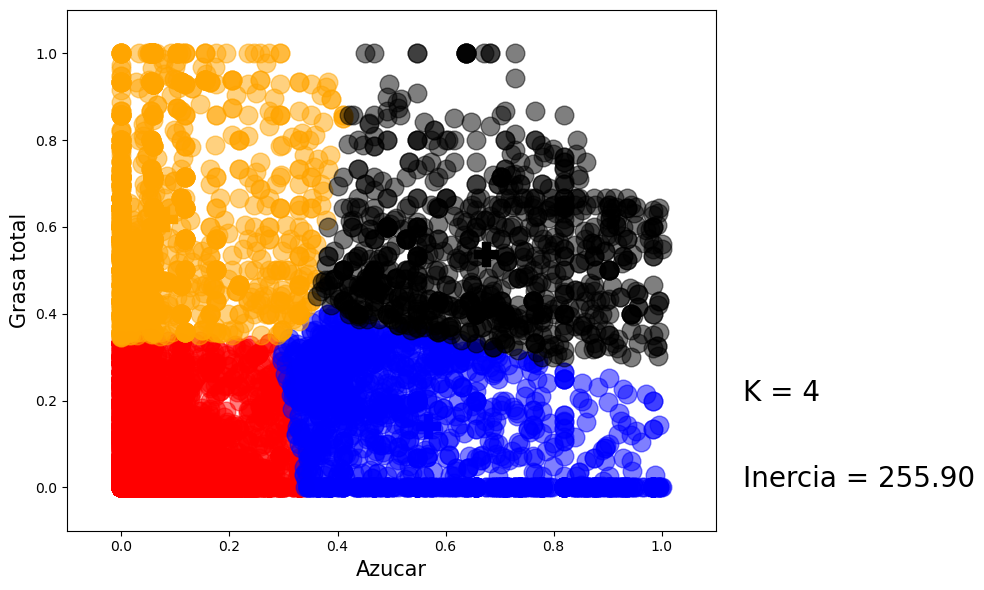

In [25]:
# Instrucciones para graficar los clusters

plt.figure(figsize=(10, 6), dpi=100)

colores = ["red", "blue", "orange", "black", "purple", "pink", "brown"]

for cluster in range(kmeans.n_clusters):
    plt.scatter(foods_scaled[foods_scaled["cluster"] == cluster]["sugar"],
                foods_scaled[foods_scaled["cluster"] == cluster]["total_fat"],
                marker="o", s=180, color=colores[cluster], alpha=0.5)

    plt.scatter(kmeans.cluster_centers_[cluster][0],
                kmeans.cluster_centers_[cluster][1],
                marker="P", s=280, color=colores[cluster])

# plt.title("Alimentos", fontsize=20)
plt.xlabel("Azucar", fontsize=15)
plt.ylabel("Grasa total", fontsize=15)
plt.text(1.15, 0.2, "K = %i" % kmeans.n_clusters, fontsize=20)
plt.text(1.15, 0, "Inercia = %0.2f" % kmeans.inertia_, fontsize=20)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.tight_layout()

# Guardar la imagen
filename = "./out-resources/clustering/fats-sugar.png"
plt.savefig(filename)
print(f"Gráfico guardado como '{filename}'")

plt.show()

del foods_scaled["cluster"]

# Método del Codo

Gráfico guardado como './out-resources/elbow_method/fats-sugar.png'


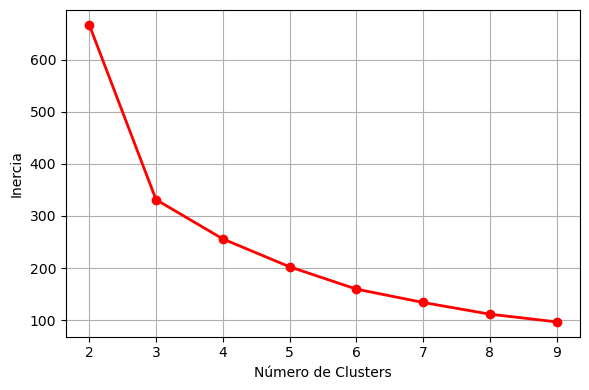

In [26]:
plot_elbow_method(foods_scaled, "fats-sugar")